In [59]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import regularAtlmask

In [83]:
datafolder = '' #Data folder

In [61]:
experiment = 'E280' 
model = 'CCSM4'

if experiment == 'E280':
    preamble = 'b40.B1850.f09_g16.preind.pop.h.'
    preamble2 = '.0081-0180.annavg.nc'
else:
    preamble = 'b40.B1850.f09_g16.PMIP4-pliomip2.pop.h.'
    preamble2 = '.1001-1100.annavg.nc'

a = 'b40.B1850.f09_g16.PMIP4-pliomip2.pop.h.MOC.1001-1100.ann.nc'
folder = datafolder+'/Raw_data/'+model+'/'

def filename(variable_string):
    filename = folder+experiment+'/'+preamble+variable_string+preamble2
    
    return filename

In [62]:
dsV = xr.open_dataset(filename('VVEL'))
dsT = xr.open_dataset(filename('TEMP'))
dsS = xr.open_dataset(filename('SALT'))
dsVNT = xr.open_dataset(filename('VNT'))
dsOHT = xr.open_dataset(filename('N_HEAT'))
dsMOC = xr.open_dataset(filename('MOC'))

if experiment == 'E280':
    dsice = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/CCSM4/E280/b40.B1850.f09_g16.preind.cam.h0.ICEFRAC.0081.0180.nc')
else:
    dsice = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/CCSM4/Eoi400/b40.B1850.f09_g16.PMIP4-pliomip2.ICEFRAC.1001.1100.nc')
    
#Obtain region mask from temperature or VNT file
if experiment == 'E280':
    ds = dsT.copy(deep=True)
else: 
    ds = dsVNT.copy(deep=True)

## Separation MOC and gyre OHT component 100-yr average

In [63]:
#Drop U-grid for temperature and T-grid for velocity (as well as some other things we don't need)
if experiment == 'E280':
    dsT = dsT.drop(['ULAT','ULONG','z_t_150m','z_w','z_w_top','z_w_bot','lat_aux_grid','moc_z'])
    dsV = dsV.drop(['TLAT','TLONG','z_t_150m','z_w','z_w_top','z_w_bot','lat_aux_grid','moc_z'])
else:
    ds = ds.drop(['ULAT','ULONG','z_t_150m','z_w','z_w_top','z_w_bot','lat_aux_grid','moc_z'])

temp = dsT.TEMP[0]
region = ds.REGION_MASK

#Regrid velocity field to the temperature field, using 0 as a fill value for land to avoid NaN ocean grid cells after interpolation
regridder = xe.Regridder(dsV, dsT, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.VVEL[0].fillna(0)
vvel = regridder(vo)

In [64]:
cp_sw = 3996.  # [J/kg/K]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

HEAT = (cp_sw*rho_sw*temp).where(ds.REGION_MASK>5).where(ds.REGION_MASK<10)  #  [J/kg/K * kg/cm^3 * degC] = [J/cm^3]

VVEL = vvel.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10) #cm/s
VVEL = VVEL*HEAT/HEAT #Fills land grid cells with NaN again

In [65]:
def zonal_means(x, dx):
    xint = (x*dx).sum('nlon')  # [x-unit * cm]
    zm = xint/dx.sum('nlon')   # [x-unit]
    return zm

#Zonal mean velocity and heat
VVEL_zm = zonal_means(VVEL, ds.DXT.where(VVEL<10000))
HEAT_zm = zonal_means(HEAT, ds.DXT.where(VVEL<10000))

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
HEAT_prime = (HEAT - HEAT_zm_3D)  # azonal heat component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*ds.DXT*ds.dz).sum(dim=['nlon','z_t'])
Haz = (VVEL_prime*HEAT_prime*ds.DXT*ds.dz).sum(dim=['nlon','z_t'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

In [66]:
# Auxiliary latitudes for OHT components
lats = ds.TLAT.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).mean('nlon')

(-0.3, 1.3)

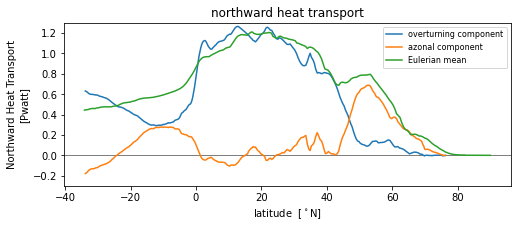

In [67]:
plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Hov.squeeze()/1e15, label='overturning component')

plt.plot(lats, Haz.squeeze()/1e15, label='azonal component')
#plt.plot(lats, (Hov+Haz).squeeze()/1e15, label='overturning+azonal')
#plt.plot(lats, (rho_sw*cp_sw*dsVNT.VNT*ds.DXT*ds.dz*ds.DYT).where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).sum(['nlon','z_t']).squeeze()/1e15, label='VNT')
dsOHT.N_HEAT.isel(transport_reg=1).isel(transport_comp=1).plot(label='Eulerian mean')
plt.title('northward heat transport')
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)
plt.ylim([-0.3, 1.3])

In [68]:
if experiment == 'E280':
    dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov[85:-1]/1e15), OHTaz=(["lat"], Haz[85:-1]/1e15)), coords = dict(lat = lats[85:-1].values))
elif experiment == 'Eoi400':
    dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov[95:-1]/1e15), OHTaz=(["lat"], Haz[95:-1]/1e15)), coords = dict(lat = lats[95:-1].values))
    
xr.Dataset.to_netcdf(dsE, path = datafolder+'/Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr mean AMOC

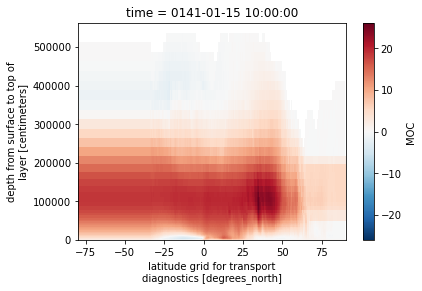

In [69]:
#Mask (almost) zero values 
a = dsMOC.MOC[0,1,0,:,:]
b = a.where(a>1e-5).fillna(0)+a.where(a<-1e-5).fillna(0)
c = b.where(b!=0)
c.plot()

In [70]:
dsM = xr.Dataset(data_vars = dict(AMOC=(("z","lat"), c.values)), coords = dict(z = (dsMOC.moc_z/100).values, lat = dsMOC.lat_aux_grid.values))
xr.Dataset.to_netcdf(dsM, path = datafolder+'/Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## Annual AMOC streamfunction (100 years)

In [71]:
#Annual MSF files
if experiment == 'E280':
    ds = xr.open_dataset(folder+experiment+'/b40.B1850.f09_g16.preind.pop.h.MOC.0081-0180.ann.nc')
else:
    ds = xr.open_dataset(folder+experiment+'/b40.B1850.f09_g16.PMIP4-pliomip2.pop.h.MOC.1001-1100.ann.nc')

In [72]:
#Mask (almost) zero values 
a = ds.MOC[:,1,0,:,:]
b = a.where(a>1e-5).fillna(0)+a.where(a<-1e-5).fillna(0)
c = b.where(b!=0)

dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), c.values)), coords = dict(time = ds['time.year'],z = (ds.moc_z/100).values, lat = ds.lat_aux_grid.values))  
xr.Dataset.to_netcdf(dsM2, path = datafolder+'/Processed/'+model+'/'+experiment+'/AMOC_annual_100yr.nc')

## 100-yr mean total Atlantic OHT

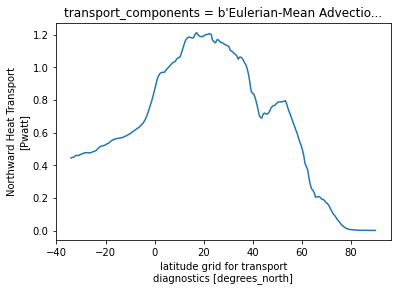

In [73]:
dsOHT.N_HEAT[0,1,1,:].plot()
dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), dsOHT.N_HEAT[0,1,1,:].values)), coords = dict(lat = dsOHT.lat_aux_grid.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'/Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

## Annual SST timeseries (100 years)

In [74]:
dstos = xr.open_dataset(folder+experiment+'/thetao_annual_100yr.nc')
dstos = dstos.drop(['ULAT','ULONG'])

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dstos, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
tos = regridder(dstos.TEMP[:,0,:,:])

dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tos.values)), coords = dict(time = tos.year.values, lat = tos.latitude.values, lon = tos.longitude.values))
xr.Dataset.to_netcdf(dsSST, path = datafolder+'/Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean SSS field (regridded)

In [75]:
if experiment == 'E280':
    dsS = dsS.drop(['ULAT','ULONG','lat_aux_grid'])

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

sss = regridder(dsS.SALT[0,0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'/Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

## 100-yr mean SI field (regridded)

In [76]:
dsi = dsice.drop('time') # To avoid error with adding different months together

djf = (dsi.ICEFRAC[11:1200:12]+dsi.ICEFRAC[0:1200:12]+dsi.ICEFRAC[1:1200:12])/3
djf = djf.mean(dim='time')

mam = (dsi.ICEFRAC[2:1200:12]+dsi.ICEFRAC[3:1200:12]+dsi.ICEFRAC[4:1200:12])/3
mam = mam.mean(dim='time')

jja = (dsi.ICEFRAC[5:1200:12]+dsi.ICEFRAC[6:1200:12]+dsi.ICEFRAC[7:1200:12])/3
jja = jja.mean(dim='time')

son = (dsi.ICEFRAC[8:1200:12]+dsi.ICEFRAC[9:1200:12]+dsi.ICEFRAC[10:1200:12])/3
son = son.mean(dim='time')

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsi, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

si_djf = regridder(djf)*sss/sss*100 #Use mask from SSS field to mark continents & convert to percentage
si_mam = regridder(mam)*sss/sss*100
si_jja = regridder(jja)*sss/sss*100
si_son = regridder(son)*sss/sss*100
si = (si_djf+si_mam+si_jja+si_son)/4

dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.latitude.values, lon = si_djf.longitude.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'/Processed/'+model+'/'+experiment+'/SI_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.a

## 100-yr mean top 100 m salinity (regridded)

In [77]:
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = ds.dz[0:10]
s100m = regridder(dsS.SALT[0,0:10].weighted(weights).mean(dim='z_t'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'/Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean salinity Atlantic

In [78]:
#Salinity
salt_atl = dsS.SALT[0]

#Regrid to 1x1 regular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

#Compute Atlantic zonal mean salinity
salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.z_t.values/100, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'/Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

## 100-yr zonal mean temperature Atlantic

In [79]:
#Temperature
temp_atl = dsT.TEMP[0]

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

#Compute Atlantic zonal mean temperature
temp_zm = temp.where(mask>-1).mean(dim='longitude')

dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.z_t.values/100, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'/Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [80]:
if experiment == 'E280':
    dsu = xr.open_dataset(folder+experiment+'/Atm/b40.B1850.f09_g16.preind.cam.h0.U.0081.0180.nc')
    dsv = xr.open_dataset(folder+experiment+'/Atm/b40.B1850.f09_g16.preind.cam.h0.V.0081.0180.nc')
else:
    dsu = xr.open_dataset(folder+experiment+'/Atm/b40.B1850.f09_g16.PMIP4-pliomip2.U.1001.1100.nc')
    dsv = xr.open_dataset(folder+experiment+'/Atm/b40.B1850.f09_g16.PMIP4-pliomip2.V.1001.1100.nc')

In [81]:
#U and V field at 1000 hPa, averaged over 100 years
ua = dsu.U[:,-1].mean(dim='time')
va = dsv.V[:,-1].mean(dim='time')

In [82]:
#Regridding to regular 1x1 grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsu, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'/Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
